In [12]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import utils.params as pars
import utils.policies as polc
import utils.experiment as expt
import utils.network as qnet
import utils.plotter as pltutils

reload(pars)
reload(polc)
reload(expt)
reload(qnet)
reload(pltutils);

## Simulation Parameters

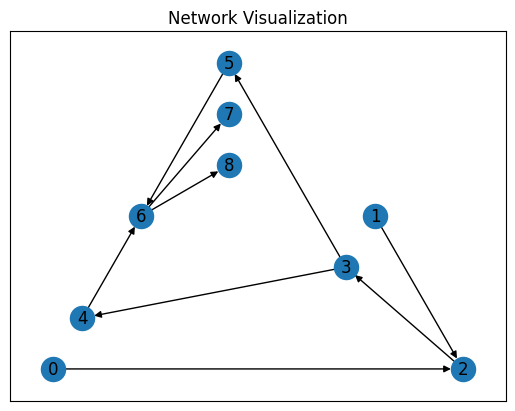

In [13]:
# get the default topology and simulation parameters
simulation_params = pars.get_simulation_params(arrival_rate_scaling=1.2)

# store some parameters locally for ease of use
T_horizon      = simulation_params.T_horizon
noise_variance = simulation_params.noise_variance
arrival_rate_scaling = simulation_params.arrival_rate_scaling

## Static Policy

In [14]:
# get static minimum rates (Theorem 1 of the paper)
stat_edge_rates, backlog_cost_C_L = polc.get_static_policy(simulation_params)

# get minimum static costs and convert them to per-time arrays
N_edges         = len(simulation_params.edge_capacities)
N_commodities   = len(simulation_params.destination_list)
stat_edge_rates = np.sum(stat_edge_rates.reshape([N_commodities, N_edges]), axis=0)
stat_cost_at_tt = (stat_edge_rates@simulation_params.true_edge_costs)*np.ones([T_horizon,])
stat_cost_till_tt = stat_cost_at_tt*np.arange(0,T_horizon)

## DPOP Policy (Unknown T, using doubling trick)

In [15]:
# intialization
T_horizon_next = 1
my_network = qnet.OnlineQueueNetwork(simulation_params, custom_seed = 13)
while(T_horizon_next < T_horizon):
    # T doubling step
    T_horizon_next = min(2*T_horizon_next, T_horizon)

    # change parameters for this value of T
    simulation_params = pars.set_simulation_params(simulation_params, T_horizon_next)
    my_network.T_horizon = T_horizon_next

    # run experiment for this value of T
    my_network = expt.run_experiment(simulation_params, queueing_network = my_network)
    
# save cost and backlog values
unknownT_tran_cost_at_tt, unknownT_tran_cost_till_tt, \
    unknownT_backlog_at_tt, unknownT_backlog_cost_at_tt = expt.calculate_per_time_metrics(my_network, backlog_cost_C_L)
unknownT_regret = unknownT_tran_cost_till_tt + unknownT_backlog_cost_at_tt - stat_cost_till_tt

## DPOP Policy (Known T, no doubling trick)

In [16]:
# change parameters for this value of T
simulation_params = pars.set_simulation_params(simulation_params, T_horizon)

# run experiment for this value of T
knownT_network = expt.run_experiment(simulation_params, custom_seed = 13)

# save cost and backlog values
knownT_tran_cost_at_tt, knownT_tran_cost_till_tt, \
    knownT_backlog_at_tt, knownT_backlog_cost_at_tt = expt.calculate_per_time_metrics(knownT_network, backlog_cost_C_L)
knownT_regret = knownT_tran_cost_till_tt + knownT_backlog_cost_at_tt - stat_cost_till_tt

## Oracle Policy

In [17]:
# change parameters for this value of T and set noise to 0 (oracle)
simulation_params.noise_variance = 0
simulation_params.beta = 0
simulation_params = pars.set_simulation_params(simulation_params, T_horizon)

# run experiment for this value of T
oracle_network = expt.run_experiment(simulation_params, custom_seed = 13)

# save cost and backlog values
oracle_tran_cost_at_tt, oracle_tran_cost_till_tt, \
    oracle_backlog_at_tt, oracle_backlog_cost_at_tt = expt.calculate_per_time_metrics(oracle_network, backlog_cost_C_L)
oracle_regret = oracle_tran_cost_till_tt + oracle_backlog_cost_at_tt - stat_cost_till_tt

## Results Comparison

In [18]:
save_result = np.vstack((stat_cost_till_tt, 
                         unknownT_tran_cost_at_tt, unknownT_backlog_at_tt,
                         unknownT_tran_cost_till_tt, unknownT_backlog_cost_at_tt,
                         knownT_tran_cost_at_tt, knownT_backlog_at_tt,
                         knownT_tran_cost_till_tt, knownT_backlog_cost_at_tt,
                         oracle_tran_cost_at_tt, oracle_backlog_at_tt,
                         oracle_tran_cost_till_tt, oracle_backlog_cost_at_tt))
save_file = 'run-lambda-' + str(arrival_rate_scaling).replace('.','_') + '-var-' + str(noise_variance).replace('.','_')
np.save('./results/' + save_file, save_result)

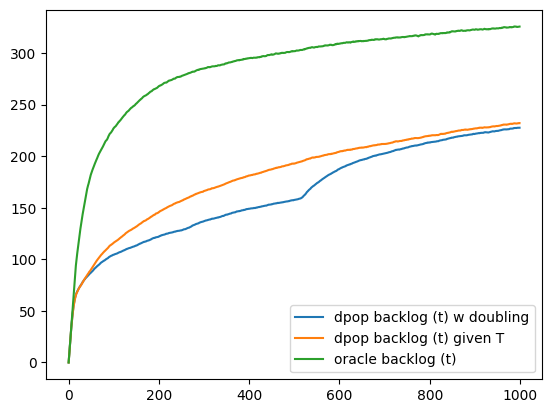

In [19]:
plt.plot(unknownT_backlog_at_tt, label = 'dpop backlog (t) w doubling')
plt.plot(knownT_backlog_at_tt, label = 'dpop backlog (t) given T')
plt.plot(oracle_backlog_at_tt, label = 'oracle backlog (t)')
plt.legend()
plt.show()

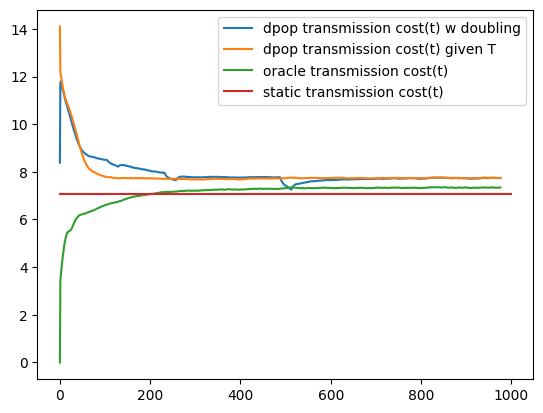

In [20]:
def windowed_average(input_array, window_size = 25):
    output_array = np.convolve(input_array, np.ones(window_size)/window_size, mode='valid')
    return np.append(input_array[0], output_array) # append used to match input and output size

plt.plot(windowed_average(unknownT_tran_cost_at_tt), label = 'dpop transmission cost(t) w doubling')
plt.plot(windowed_average(knownT_tran_cost_at_tt), label = 'dpop transmission cost(t) given T')
plt.plot(windowed_average(oracle_tran_cost_at_tt), label = 'oracle transmission cost(t)')
plt.plot(stat_cost_at_tt, label = 'static transmission cost(t)')
plt.legend()
plt.show()

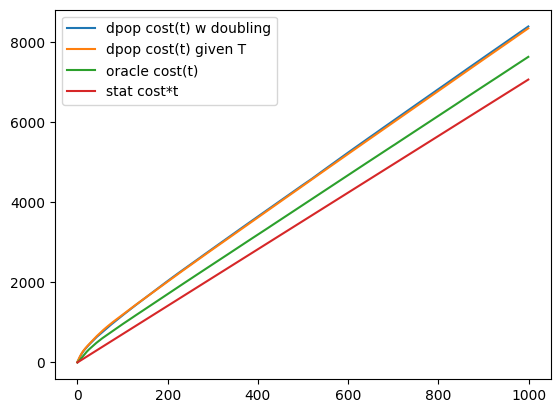

In [21]:
plt.plot(unknownT_tran_cost_till_tt + unknownT_backlog_cost_at_tt, label = 'dpop cost(t) w doubling')
plt.plot(knownT_tran_cost_till_tt + knownT_backlog_cost_at_tt, label = 'dpop cost(t) given T')
plt.plot(oracle_tran_cost_till_tt + oracle_backlog_cost_at_tt, label = 'oracle cost(t)')
plt.plot(stat_cost_till_tt, label = 'stat cost*t')
plt.legend()
plt.show()

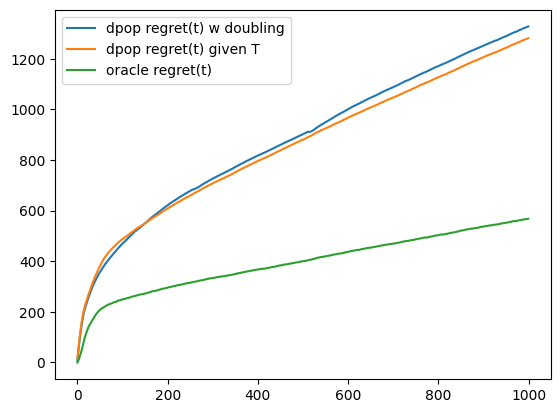

In [22]:
plt.plot(unknownT_regret, label = 'dpop regret(t) w doubling')
plt.plot(knownT_regret, label = 'dpop regret(t) given T')
plt.plot(oracle_regret, label = 'oracle regret(t)')
plt.legend()
plt.show()

In [25]:
knownT_network.edge_num_pulls[0]

array([ 605.,  569.,  654., 1001.,  163.,  931.,  749.,  452.,  545.])